# Term 1 Project 4: Advanced Lane Finding

The goals / steps of this project are the following:

1. Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
2. Apply a distortion correction to raw images.
3. Use color transforms, gradients, etc., to create a thresholded binary image.
4. Apply a perspective transform to rectify binary image ("birds-eye view").
5. Detect lane pixels and fit to find the lane boundary.
6. Determine the curvature of the lane and vehicle position with respect to center.
7. Warp the detected lane boundaries back onto the original image.
8. Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

# Part 1 Illustrate the Individual Steps

## Imports

In [148]:
import numpy as np
import cv2
import pickle
import glob
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

## 1. Camera Calibration using Chessboard Images

### Find Corner Points on the Chessboard Images

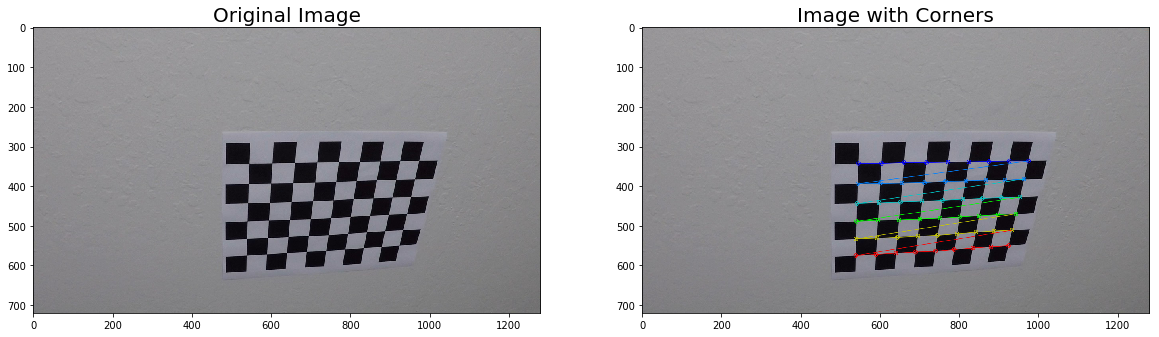

In [149]:
# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9, 0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('camera_cal/calibration*.jpg')

# Step through the list and search for chessboard corners
for idx, fname in enumerate(images):
    img = mpimg.imread(fname)
    
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6), None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        cv2.drawChessboardCorners(img, (9,6), corners, ret)
        
        # Save image with corners
        filename = os.path.basename(fname)
        basename = os.path.splitext(filename)[0]
        newname = 'output_images/' + basename + '_corners.jpg'

        cv2.imwrite(newname, img)

        # Example display of result
        if(idx == 1):
            f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
            ax1.imshow(mpimg.imread(fname))
            ax1.set_title('Original Image', fontsize=20)
            ax2.imshow(img)
            ax2.set_title('Image with Corners', fontsize=20)    

### Calculate Calibration Matrix and Test Undistortion

Text(0.5,1,'Undistorted Image')

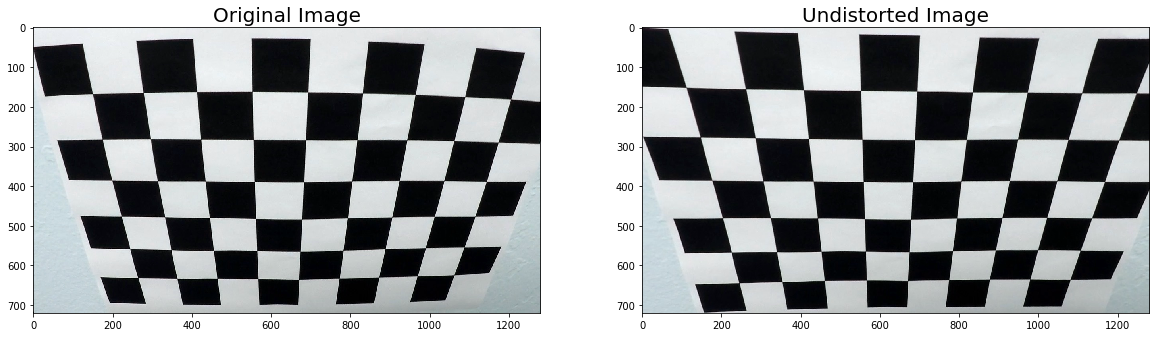

In [150]:
# Helper function to undistort image
def undistort(img, mtx, dist):
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    return undist

# Read image for testing undistortion
img = cv2.imread('camera_cal/calibration2.jpg')
img_size = (img.shape[1], img.shape[0])

# Calculate camera calibration data using object points and image points
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size, None,None)

# Undistort the image
undistorted_img = undistort(img, mtx, dist)

# Save undistorted image
cv2.imwrite('output_images/calibration2_undistorted.jpg', undistorted_img)

# Save the camera calibration result for later use (we won't worry about rvecs / tvecs)
dist_pickle = {}
dist_pickle["mtx"] = mtx
dist_pickle["dist"] = dist
pickle.dump( dist_pickle, open( "calibration.p", "wb" ) )

# Example of original and distorted images
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=20)
ax2.imshow(undistorted_img)
ax2.set_title('Undistorted Image', fontsize=20)    

## 2. Distortion Correction of Test Images

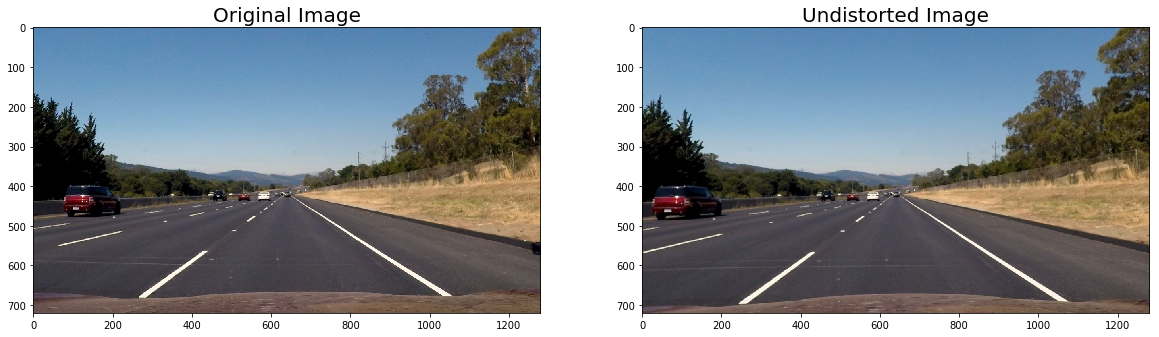

In [151]:
# Read the test images
input_folder = "test_images/"
filenames = os.listdir(input_folder)

test_images = [mpimg.imread(os.path.join(input_folder, filename)) for filename in filenames]

for i in range(len(filenames)):
    undist = undistort(test_images[i], mtx, dist)
    
    # Example of result
    if(i == 1):
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
        ax1.imshow(test_images[i])
        ax1.set_title('Original Image', fontsize=20)
        ax2.imshow(undist)
        ax2.set_title('Undistorted Image', fontsize=20)            

## 3. Create Thresholded Binary Images

In [152]:
# Define a function that applies Sobel x or y, 
# then takes an absolute value and applies a threshold.
# Assume gray scaled input image
def abs_sobel_thresh(gray, orient='x', sobel_kernel=3, thresh=(0, 255)):
    
    # Apply the following steps to img
    # 1) Convert to grayscale
#    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    # 2) Take the derivative in x or y given orient = 'x' or 'y'
    if orient == 'x':
        sobel = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    else:
        sobel = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    
    # 3) Take the absolute value of the derivative or gradient
    abs_sobel = np.absolute(sobel)
    
    # 4) Scale to 8-bit (0 - 255) then convert to type = np.uint8
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))  
    
    # 5) Create a mask of 1's where the scaled gradient magnitude 
            # is > thresh_min and < thresh_max
    sbinary = np.zeros_like(scaled_sobel)
    sbinary[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1  
    
    # 6) Return this mask as your binary_output image
    return(sbinary)

# Define a function that applies Sobel x and y, 
# then computes the direction of the gradient
# and applies a threshold.
# Assume gray scaled input image
def dir_threshold(gray, sobel_kernel=3, thresh=(0, np.pi/2)):
    
    # Apply the following steps to img
    # 1) Convert to grayscale
#    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    # 2) Take the gradient in x and y separately
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)

    # 3) Take the absolute value of the x and y gradients
    abs_sobelx = np.absolute(sobelx)
    abs_sobely = np.absolute(sobely)    

    # 4) Use np.arctan2(abs_sobely, abs_sobelx) to calculate the direction of the gradient 
    direction = np.arctan2(abs_sobely, abs_sobelx)
    
    # 5) Create a binary mask where direction thresholds are met
    binary_output = np.zeros_like(direction)
    binary_output[(direction >= thresh[0]) & (direction <= thresh[1])] = 1  

    # 6) Return this mask as your binary_output image
    return binary_output

In [153]:
# This function returns a combination of all the thresholds for the input image
# The image is raw; i.e. has not been undistorted.
# The image is in RGB format and undistorted
# The function use predetermined camera matrix and distortion coefficients
def get_thresholded_image(img): 
    # Convert to gray here to avoid doing it multiple times
    gray = cv2.cvtColor(undistorted_img, cv2.COLOR_RGB2GRAY)
    
    height, width = gray.shape

    # Calculate the gradient threshold in the horizontal direction
    grad_binary = abs_sobel_thresh(gray, orient='x', sobel_kernel=15, thresh=(45,100))
    
    # Calculate the gradient direction threshold to detect only edges close to vertical are detected
    dir_binary = dir_threshold(gray, sobel_kernel=15, thresh=(0.7, 1.3))

    # Combine the gradient and the gradient direction thresholds
    sobel_combined = np.zeros_like(dir_binary)
    sobel_combined = ((grad_binary == 1) & (dir_binary == 1))
    
    # Now apply color selection on  the image in HLS format
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    h_channel = hls[:,:,0]
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]

    # Threshold H channel
    h_thresh_min = 10
    h_thresh_max = 40
    h_binary = np.zeros_like(h_channel)
    h_binary[(h_channel > h_thresh_min) & (h_channel <= h_thresh_max)] = 1

    # Threshold L channel
    l_thresh_min = 200
    l_thresh_max = 255
    l_binary = np.zeros_like(l_channel)
    l_binary[(l_channel > l_thresh_min) & (l_channel <= l_thresh_max)] = 1
    
    # Threshold S channel
    s_thresh_min = 100
    s_thresh_max = 255
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel > s_thresh_min) & (s_channel <= s_thresh_max)] = 1
        
    # We use the L channel for white selection and combine the H and S channels
    # for yellow selection
    combined_binary = np.zeros_like(grad_binary)
    combined_binary[(((s_binary == 1) & (h_binary == 1)) | (l_binary == 1)) | (sobel_combined == 1)] = 1

    return combined_binary

Text(0.5,1,'Thresholded')

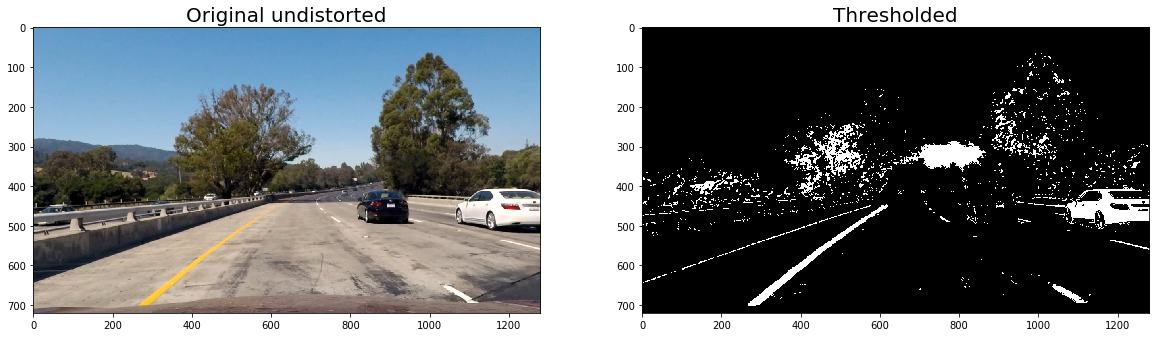

In [174]:
#img = mpimg.imread('test_images/straight_lines1.jpg')
img = mpimg.imread('test_images/test1.jpg')
undistorted_img = undistort(img, mtx, dist)

thresholded_image = get_thresholded_image(undistorted_img)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(undistorted_img)
ax1.set_title("Original undistorted", fontsize=20)
ax2.imshow(thresholded_image, cmap='gray')
ax2.set_title("Thresholded", fontsize=20)    

### Crop to area of interest

In [175]:
def crop_to_area_of_interest(im):
    # Define the corners of the area of interest
    max_y = im.shape[0] # Max y value
    max_x = im.shape[1] # Max x value
    
    # Define the polygon
    bottom_left = [int(max_x*0.05), max_y] # cv2.fillPoly would like the points in the (x,y) form
#    print(bottom_left)
    bottom_right = [int(max_x*0.95), max_y]
#    print(bottom_right)
    top_left = [int(max_x*0.47), int(max_y*0.60)]
#    print(top_left)
    top_right = [int(max_x*0.53), int(max_y*0.60)]
#    print(top_right)
    
    # Define the polygon as an array of points
    polygon = [bottom_left, top_left, top_right, bottom_right]
    
    # Create copy of input image with same shape and all values set to 0 (black)
    area_mask = np.zeros_like(im)
    
    # Set all values inside the polygon to 255 (white)
    cv2.fillPoly(area_mask, np.array([polygon]), 255)
    
    # Use bitwise_and to return a new image containing only the parts inside the polygon
    # the rest set to black
    return( cv2.bitwise_and(im, area_mask) )

Text(0.5,1,'Cropped Image')

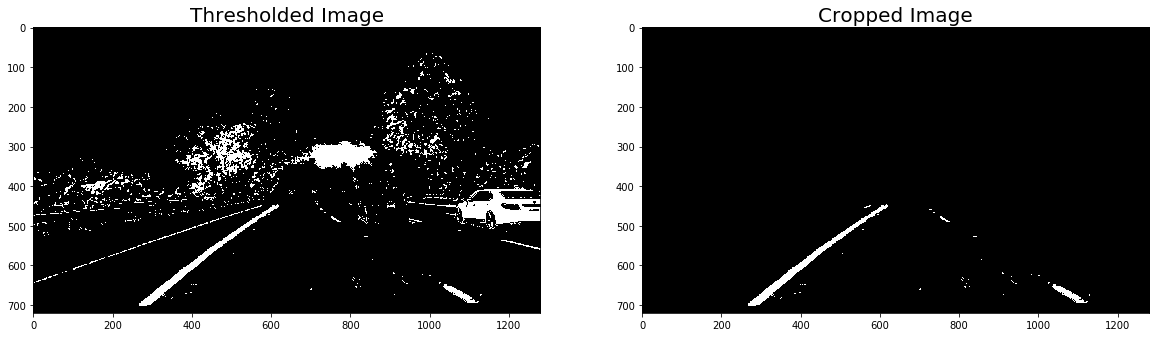

In [176]:
cropped_image = crop_to_area_of_interest(thresholded_image)
    
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(thresholded_image, cmap='gray')
ax1.set_title("Thresholded Image", fontsize=20)
ax2.imshow(cropped_image, cmap='gray')
ax2.set_title("Cropped Image", fontsize=20)    

## 4. Perspective Transform

Text(0.5,1,'Warped Image')

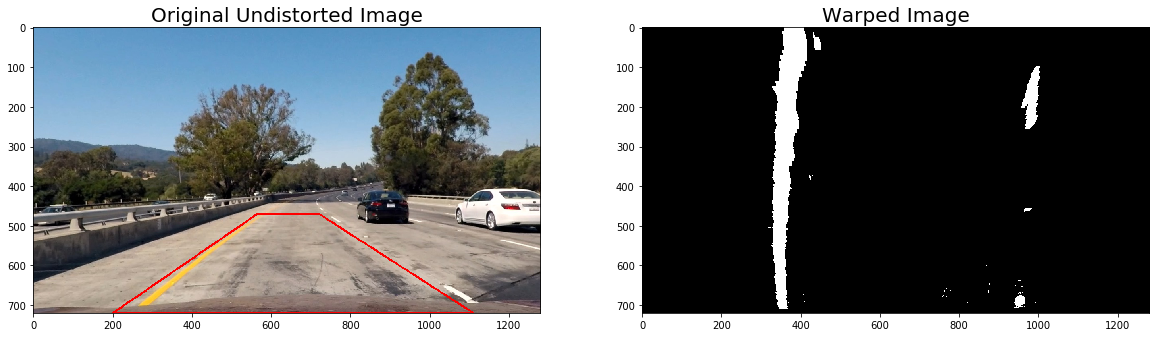

In [177]:
# Source points manually determined by inspecting test images
src_bottom_left = [200, 720]
src_bottom_right = [1110, 720]
src_top_left = [565, 470]
src_top_right = [720, 470]
src_point = np.float32([src_bottom_left, src_bottom_right, src_top_right, src_top_left])

# Destination points chosen to let straight lines be parallel in the warped image
dst_bottom_left = [320, 720]
dst_bottom_right = [920, 720]
dst_top_left = [320, 1]
dst_top_right = [920, 1]
dst_point = np.float32([[dst_bottom_left, dst_bottom_right, dst_top_right, dst_top_left]])

# Calculate the transformation matrix, and its inverse
M = cv2.getPerspectiveTransform(src_point, dst_point)
M_inv = cv2.getPerspectiveTransform(dst_point, src_point) # For later usage

img_size = (cropped_image.shape[1], cropped_image.shape[0])

# Let's do the space warp again
binary_warped = cv2.warpPerspective(cropped_image, M, img_size, flags=cv2.INTER_LINEAR)

# Draw the lines between the source points on a copy of the original image
pts = np.array([src_bottom_left, src_bottom_right, src_top_right, src_top_left], np.int32)
pts = pts.reshape((-1,1,2))
draw_copy = undistorted_img.copy()
cv2.polylines(draw_copy, [pts], True, (255,0,0), thickness=3)

# Show what we just did.
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(draw_copy)
ax1.set_title("Original Undistorted Image", fontsize=20)
ax2.imshow(binary_warped, cmap='gray')
ax2.set_title("Warped Image", fontsize=20)    

## 5. Detect Lane Pixels

### Sliding Window Search

In [159]:
# Get current size
fig_size = plt.rcParams["figure.figsize"]
print("Current size:", fig_size)

# Set figure width to 12 and height to 8
fig_size[0] = 12
fig_size[1] = 8
plt.rcParams["figure.figsize"] = fig_size

Current size: [6.0, 4.0]


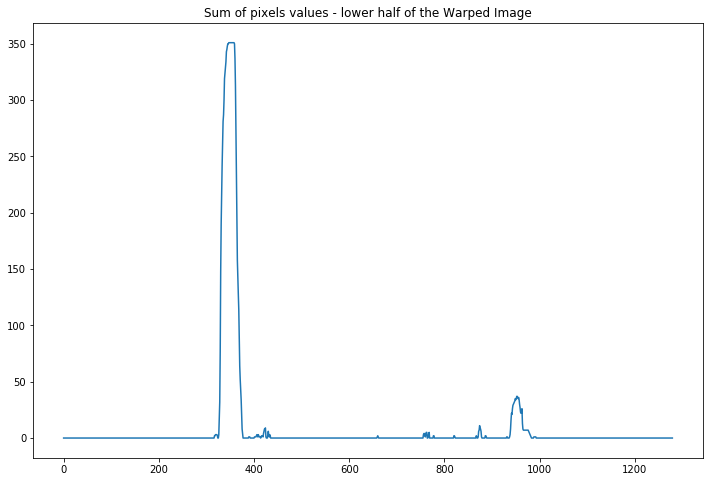

(720, 0)

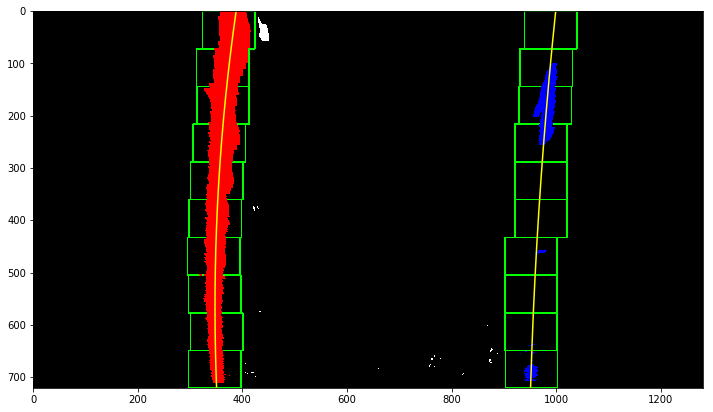

In [178]:
# Assume we have a start image called binary_warped
# Take a histogram of the bottom half of the image.
# Use the floor division operator '//' to calculate how large the lower half is
# Pixel values are between 0 (black) and 255 (white), so the histogram will
# show where on the x-axis the image contains the most information
histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)

plt.plot(histogram)
plt.title('Sum of pixels values - lower half of the Warped Image')
plt.show()

# Create an output image to draw on and visualize the result
out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255

# Find the peak of the left and right halves of the histogram
# These will be the starting point for the left and right lines
midpoint = np.int(histogram.shape[0]/2)
leftx_base = np.argmax(histogram[:midpoint])
rightx_base = np.argmax(histogram[midpoint:]) + midpoint

# Choose the number of sliding windows
nwindows = 10
# Set height of windows
window_height = np.int(binary_warped.shape[0]/nwindows)

# Identify the x and y positions of all nonzero pixels in the image
nonzero = binary_warped.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])

# Current positions to be updated for each window
leftx_current = leftx_base
rightx_current = rightx_base

# Set the width of the windows +/- margin
margin = 50
# Set minimum number of pixels found to recenter window
minpix = 100

# Create empty lists to receive left and right lane pixel indices
left_lane_inds = []
right_lane_inds = []

# Step through the windows one by one
for window in range(nwindows):
    # Identify window boundaries in x and y (and right and left)
    win_y_low = binary_warped.shape[0] - (window+1)*window_height
    win_y_high = binary_warped.shape[0] - window*window_height
    win_xleft_low = leftx_current - margin
    win_xleft_high = leftx_current + margin
    win_xright_low = rightx_current - margin
    win_xright_high = rightx_current + margin
    
    # Draw the windows on the visualization image
    cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),
    (0,255,0), 2) 
    cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),
    (0,255,0), 2) 
    
    # Identify the nonzero pixels in x and y within the window
    good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
    (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
    good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
    (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
    
    # Append these indices to the lists
    left_lane_inds.append(good_left_inds)
    right_lane_inds.append(good_right_inds)
    
    # If you found > minpix pixels, recenter next window on their mean position
    if len(good_left_inds) > minpix:
        leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
    if len(good_right_inds) > minpix:        
        rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
        
# Concatenate the arrays of indices
left_lane_inds = np.concatenate(left_lane_inds)
right_lane_inds = np.concatenate(right_lane_inds)

# Extract left and right line pixel positions
leftx = nonzerox[left_lane_inds]
lefty = nonzeroy[left_lane_inds] 
rightx = nonzerox[right_lane_inds]
righty = nonzeroy[right_lane_inds] 

# Fit a second order polynomial to each
left_fit = np.polyfit(lefty, leftx, 2)
right_fit = np.polyfit(righty, rightx, 2)
    
# Visualize result
ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
plt.imshow(out_img)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)

### Search Around Known Lines

(720, 0)

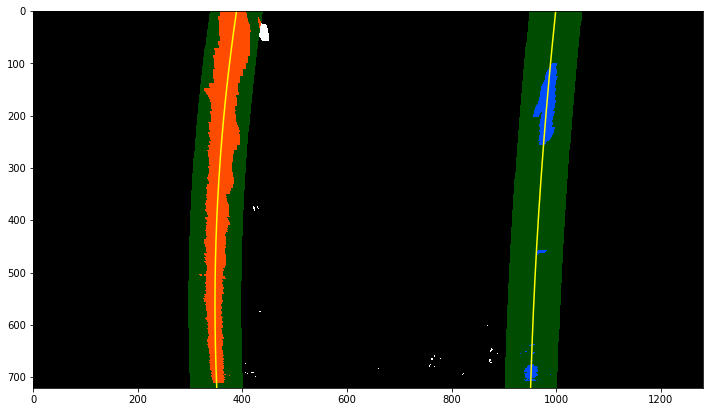

In [179]:
# Assume image called binary_warped and known previous lines called left_fit and right_fit

nonzero = binary_warped.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])
margin = 50
left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
    left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
    left_fit[1]*nonzeroy + left_fit[2] + margin))) 

right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
    right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
    right_fit[1]*nonzeroy + right_fit[2] + margin)))  

# Again, extract left and right line pixel positions
leftx = nonzerox[left_lane_inds]
lefty = nonzeroy[left_lane_inds] 
rightx = nonzerox[right_lane_inds]
righty = nonzeroy[right_lane_inds]
    
# Fit a second order polynomial to each
left_fit = np.polyfit(lefty, leftx, 2)
right_fit = np.polyfit(righty, rightx, 2)
    
# Generate x and y values for plotting
ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
# Create an image to draw on and an image to show the selection window
out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
window_img = np.zeros_like(out_img)
# Color in left and right line pixels
out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

# Generate a polygon to illustrate the search window area
# And recast the x and y points into usable format for cv2.fillPoly()
left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                                  ploty])))])
left_line_pts = np.hstack((left_line_window1, left_line_window2))
right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, ploty])))])
right_line_pts = np.hstack((right_line_window1, right_line_window2))

# Draw the lane onto the warped blank image
cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
plt.imshow(result)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)

## 6. Determine Line Curvature and Center Offset

### Line Curvature

In [180]:
# Define y-value where we want radius of curvature
# Here we ise the maximum y-value, corresponding to the bottom of the image
y_eval = np.max(ploty)

# Define conversions in x and y from pixels space to meters
ym_per_pix = 30/720 # meters per pixel in y dimension
xm_per_pix = 3.7/700 # meters per pixel in x dimension assuming lane is about 700 pixels wide in the image

# Fit new polynomials to x,y in world space
left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)

# Calculate the new radii of curvature
left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])

# Now our radius of curvature is in meters
average_curvature = (left_curverad + right_curverad)/2
print("Curvature = " + str(average_curvature) + " meters")

Curvature = 2193.1123464873726 meters


### Center Offset

In [181]:
# Use the x value of the fitted polynomial at the very bottom of the image
lane_center = (left_fitx[719] + right_fitx[719]) / 2
center_offset_in_pixels = abs(img_size[0]/2 - lane_center)
# We calculate img_size when we did the perspective transform
center_offset_in_meters = xm_per_pix * center_offset_in_pixels
print("Offset from center = " + str(center_offset_in_meters) + " meters")

Offset from center = 0.058654503104140894 meters


## 7. Warp Lanes Back on Original Image

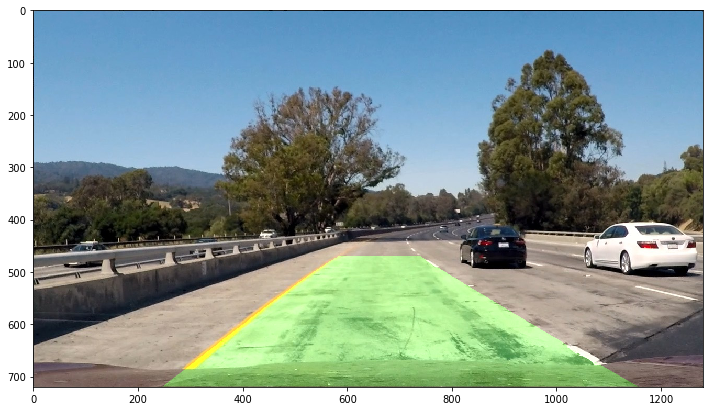

In [182]:
# Create an image to draw the lines on
warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

# Recast the x and y points into usable format for cv2.fillPoly()
pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
pts = np.hstack((pts_left, pts_right))

# Draw the lane onto the warped blank image
cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

# Warp the blank back to original image space using inverse perspective matrix (M_inv)
newwarp = cv2.warpPerspective(color_warp, M_inv, (img.shape[1], img.shape[0])) 
# Combine the result with the original image
result = cv2.addWeighted(img, 1, newwarp, 0.3, 0)
plt.imshow(result)

## 8. Output Curvature and Offset on Result Image

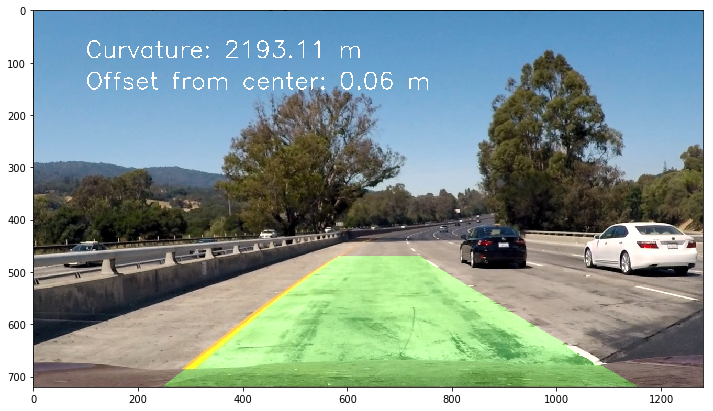

In [183]:
curvature_str = "Curvature: %.2f m" % average_curvature
offset_str = "Offset from center: %.2f m" % center_offset_in_meters

cv2.putText(result, curvature_str, (100,90), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (255,255,255), thickness=2)
cv2.putText(result, offset_str, (100,150), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (255,255,255), thickness=2)

plt.imshow(result)

# Part 2 The Pipeline for Video Stream Processing

In the following I will use the code from above for a pipeline for processing a video stream.
We will assume the existence of a camera matrix mtx and distortion coefficients dist, as calculated in part 1 above.

In [268]:
# This function takes an image as input and returns the warped and thresholded image
# The function assumes existence of distortion matrix mtx, coefficients dist and warp matrix M
# We will use functions created in part 1 above.
def getWarped(img):
#    undistorted_img = undistort(img, mtx, dist) # See part 1, assume known mtx and dist
    thresholded_image = get_thresholded_image(img) # See part 1
    cropped_image = crop_to_area_of_interest(thresholded_image) # See part 1
    
    img_size = (cropped_image.shape[1], cropped_image.shape[0])

    # Let's do the space warp again
    bin_warp = cv2.warpPerspective(cropped_image, M, img_size, flags=cv2.INTER_LINEAR)

    return bin_warp

Text(0.5,1,'Warped Image')

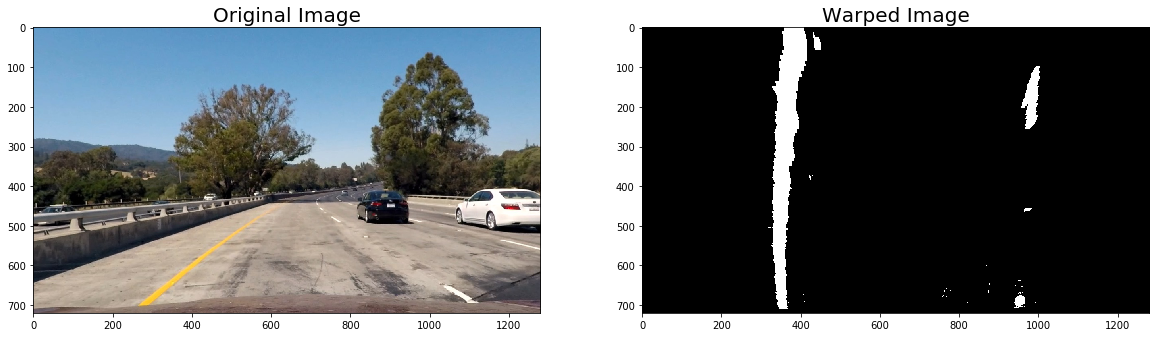

In [269]:
org_img = mpimg.imread('test_images/test1.jpg')
test_img = undistort(org_img, mtx, dist) # See part 1, assume known mtx and dist

warped_im = getWarped(test_img)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(test_img)
ax1.set_title("Original Image", fontsize=20)
ax2.imshow(warped_im, cmap='gray')
ax2.set_title("Warped Image", fontsize=20)    

Next I will write functions for performing the sliding windows polyfit and the polyfit based on previous fit, reusing the code from part 1, but fitting it into functions.

In [270]:
# This function takes a warped and thresholded image as input and returns the found second order
# polynomial for left and right lanes, if anything is found. If not it returns None, None
# Function also returns the list of indices of the identified left and right lane pixels
def getSlidingWindowPolyFit(binary_warped):
    # Take a histogram of the bottom half of the image.
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)

    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Number of sliding windows
    nwindows = 10
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)

    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])

    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Set the width of the windows +/- margin
    margin = 50
    # Set minimum number of pixels found to recenter window
    minpix = 50

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
    
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
    
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
    
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
        
    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    left_fit, right_fit = (None, None)
    
    # Fit a second order polynomial to each
    if(len(leftx) != 0):
        left_fit = np.polyfit(lefty, leftx, 2)
    if(len(rightx) != 0):
        right_fit = np.polyfit(righty, rightx, 2)
        
    left_fit_bottom = left_fit[0]*(binary_warped.shape[0]-1)**2 + left_fit[1]*(binary_warped.shape[0]-1) + left_fit[2]
    right_fit_bottom = right_fit[0]*(binary_warped.shape[0]-1)**2 + right_fit[1]*(binary_warped.shape[0]-1) + right_fit[2]

    left_fit_top = left_fit[2]
    right_fit_top = right_fit[2]
    
    distance_bottom = right_fit_bottom - left_fit_bottom
    distance_top = right_fit_top - left_fit_top
    
#    print(distance_top)
#    print(distance_bottom)
#    print(abs(distance_top - distance_bottom))
    
#    if(abs(distance_top - distance_bottom) < 40):
    if(distance_top < 620):
        return left_fit, right_fit, left_lane_inds, right_lane_inds
    else:
        return None, None, [], []

We need a function to draw the identified lane lines back to original image

In [271]:
def DrawLanes(original_img, binary_warped, left_fit, right_fit, Minv):
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (M_inv)
    newwarp = cv2.warpPerspective(color_warp, M_inv, (original_img.shape[1], original_img.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(original_img, 1, newwarp, 0.3, 0)
    return result   

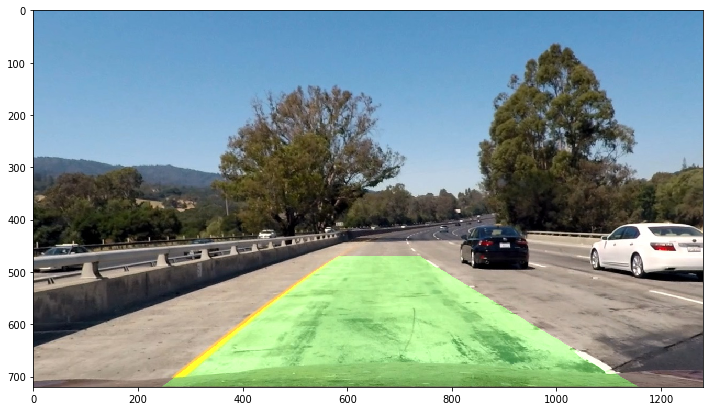

In [272]:
left_fit, right_fit, left_lane_inds, right_lane_inds = getSlidingWindowPolyFit(warped_image)
result = DrawLanes(test_img, warped_image, left_fit, right_fit, M_inv)
plt.imshow(result) 

In [273]:
# This function takes a warped and thresholded image as input as well a previously found left and right
# second order ploynomials. The function and returns the newfound second order
# polynomial for left and right lanes, if anything is found. If not it returns None, None
# Function also returns the list of indices of the identified left and right lane pixels
def getPolyfitBasedOnPreviousFit(binary_warped, prev_left_fit, prev_right_fit):
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 50
    
    # Create empty lists for left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    left_lane_inds = ((nonzerox > (prev_left_fit[0]*(nonzeroy**2) + prev_left_fit[1]*nonzeroy + 
        prev_left_fit[2] - margin)) & (nonzerox < (prev_left_fit[0]*(nonzeroy**2) + 
        prev_left_fit[1]*nonzeroy + prev_left_fit[2] + margin))) 

    right_lane_inds = ((nonzerox > (prev_right_fit[0]*(nonzeroy**2) + prev_right_fit[1]*nonzeroy + 
        prev_right_fit[2] - margin)) & (nonzerox < (prev_right_fit[0]*(nonzeroy**2) + 
        prev_right_fit[1]*nonzeroy + prev_right_fit[2] + margin)))  

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    left_fit, right_fit = (None, None)
    
    # Fit a second order polynomial to each
    if(len(leftx) != 0):
        left_fit = np.polyfit(lefty, leftx, 2)
    if(len(rightx) != 0):
        right_fit = np.polyfit(righty, rightx, 2)

    left_fit_bottom = left_fit[0]*(binary_warped.shape[0]-1)**2 + left_fit[1]*(binary_warped.shape[0]-1) + left_fit[2]
    right_fit_bottom = right_fit[0]*(binary_warped.shape[0]-1)**2 + right_fit[1]*(binary_warped.shape[0]-1) + right_fit[2]

    left_fit_top = left_fit[2]
    right_fit_top = right_fit[2]
    
    distance_bottom = right_fit_bottom - left_fit_bottom
    distance_top = right_fit_top - left_fit_top

#    print(distance_top)
#    print(distance_bottom)
#    print(abs(distance_top - distance_bottom))

#    if(abs(distance_top - distance_bottom) < 40):
    if(distance_top < 620):
        return left_fit, right_fit, left_lane_inds, right_lane_inds
    else:
        return None, None, [], []        

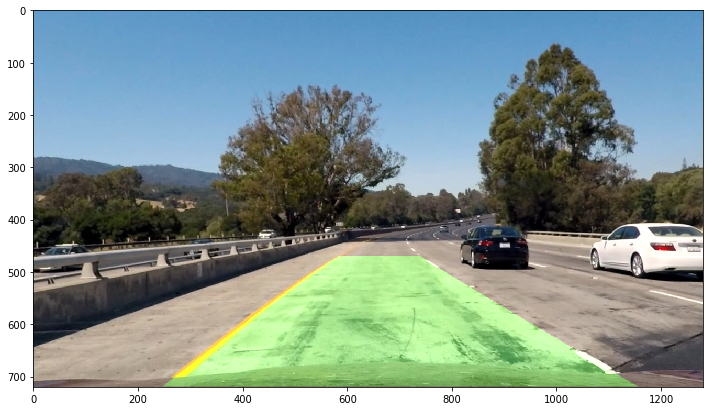

In [274]:
left_fit, right_fit, left_lane_inds, right_lane_inds = getPolyfitBasedOnPreviousFit(warped_image, left_fit, right_fit)
result = DrawLanes(test_img, warped_image, left_fit, right_fit, M_inv)
plt.imshow(result) 

In [275]:
# This function calculates curvature and offset from lane center.
# Inputs are binary image, left and right polynomial fits and pixel indices for left and right lanes
def calculateCurvatureAndOffSet(binary_warped, left_fit, right_fit, left_lane_inds, right_lane_inds):
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension assuming lane is about 700 pixels wide in the image
    average_curvature = 0
    
    # Define y-value where we want radius of curvature
    # Here we ise the maximum y-value, corresponding to the bottom of the image
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    y_eval = np.max(ploty)

    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    if(len(leftx) != 0 and len(rightx)!= 0):
        # Fit new polynomials to x,y in world space
        left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
        right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)

        # Calculate the new radii of curvature
        left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
        right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
        
    if( left_fit is not None and right_fit is not None ):
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
        
        # Use the x value of the fitted polynomial at the very bottom of the image
        lane_center = (left_fitx[719] + right_fitx[719]) / 2
        center_offset_in_pixels = binary_warped.shape[1]/2 - lane_center
        center_offset_in_meters = xm_per_pix * center_offset_in_pixels
    
    return left_curverad, right_curverad, center_offset_in_meters

def writeDataOnImage(img, average_curvature, center_offset_in_meters):  
    curvature_str = "Curvature: %.2f m" % average_curvature
    if(center_offset_in_meters > 0):
        offset_str = "Right offset from center: %.2f m" % center_offset_in_meters
    elif(center_offset_in_meters < 0):
        offset_str = "Left offset from center: %.2f m" % abs(center_offset_in_meters)
    else:
        offset_str = "No offset from center"
    
    cv2.putText(img, curvature_str, (100,90), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (255,255,255), thickness=2)
    cv2.putText(img, offset_str, (100,150), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (255,255,255), thickness=2)
    
    return img

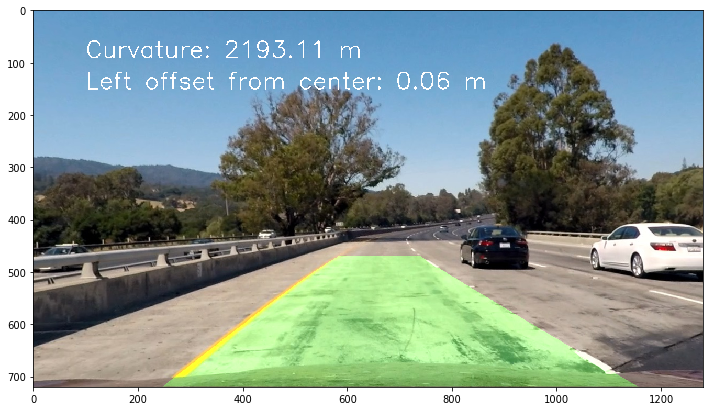

In [276]:
left_curvature, right_curvature, center_offset_in_meters = calculateCurvatureAndOffSet(warped_image, left_fit, right_fit, left_lane_inds, right_lane_inds)

average_curvature = (left_curvature + right_curvature)/2

result = writeDataOnImage(result, average_curvature, center_offset_in_meters)
plt.imshow(result)

Last step is to put the Line class to use. I will use the class to store the last n fits, and to calculate the
averaged best fit based on this window of n fits.

In [277]:
# Define a class to receive the characteristics of each line detection
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.current_fit = []  
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #x values for detected line pixels
        self.allx = None  
        #y values for detected line pixels
        self.ally = None
    
    def add_radius_of_curvature(self, radius):
        if(abs(radius) > 100 and abs(radius) < 10000):
            self.radius_of_curvature = radius
            
    def add_line_base_pos(self, pos):
        if(abs(pos) < 3.7):
            self.line_base_pos = pos
        
    def add_new_fit(self, new_fit):
        # If the new fit is empty remove the oldest entry in the window
        # and recalculate the average
        if new_fit is None:
            self.detected = False
            
            if(len(self.current_fit) > 1):
                # Use slicing to remove first (oldest) element
                self.current_fit = self.current_fit[1:]

            # Calculate new average fit
            if(len(self.current_fit) > 0):
                self.best_fit = np.average(self.current_fit, axis=0)
            else: # No more elements so no average can be calculated
                self.best_fit = None
        else: # The new_fit is a polynomial
            self.detected = True
            self.current_fit.append(new_fit)
            if(len(self.current_fit) > 24):
                # Use slicing to remove first (oldest) element
                self.current_fit = self.current_fit[1:]
        
            # Calculate new average fit
            self.best_fit = np.average(self.current_fit, axis=0)
            
    def get_best_fit(self):
        return(self.best_fit)
    
    def get_detected(self):
        return(self.detected)
    
    def get_radius_of_curvature(self):
        return(self.radius_of_curvature)
    
    def get_line_base_pos(self):
        return(self.line_base_pos)

In [278]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [281]:
# This function process 1 image from a video stream
# It assume the existence of global variables called left_line and right_line which are instances of
# the Line class
def process_image(image):
    img_copy = np.copy(image)

    img_undistorted = undistort(img_copy, mtx, dist) # See part 1, assume known mtx and dist

    img_warped = getWarped(img_undistorted)
    
    if left_line.get_detected() == False or right_line.get_detected() == False:
        left_fit, right_fit, left_lane_inds, right_lane_inds = getSlidingWindowPolyFit(img_warped)
    else:
        left_fit, right_fit, left_lane_inds, right_lane_inds = getPolyfitBasedOnPreviousFit(img_warped,
                                                               left_line.get_best_fit(), right_line.get_best_fit())   
 
    if left_fit is not None and right_fit is not None:
        if(np.sign(left_fit[0]) != np.sign(right_fit[0])):
            left_fit = None
            right_fit = None

    left_line.add_new_fit(left_fit)
    right_line.add_new_fit(right_fit)
    
    if(left_fit is not None and right_fit is not None and len(left_lane_inds > 0) and len(right_lane_inds > 0)):
        left_curv, right_curv, center_offset = calculateCurvatureAndOffSet(img_warped, 
                                                   left_fit, right_fit, left_lane_inds, right_lane_inds)
        left_line.add_radius_of_curvature(left_curv)
        right_line.add_radius_of_curvature(right_curv)
        left_line.add_line_base_pos(center_offset)

    left_best_fit = left_line.get_best_fit()
    right_best_fit = right_line.get_best_fit()

    if left_best_fit is not None and right_best_fit is not None:
        img_result = DrawLanes(img_undistorted, img_warped, left_best_fit, right_best_fit, M_inv)
        
        l_c = left_line.get_radius_of_curvature()
        r_c = right_line.get_radius_of_curvature()
        offset = left_line.get_line_base_pos()
        if l_c is not None and r_c is not None and offset is not None:
            average_curv = (l_c + r_c)/2
            img_result = writeDataOnImage(img_result, average_curv, offset)
    else:
        img_result = img_undistorted
        
    return img_result

In [283]:
left_line = Line()
right_line = Line()

video_output = 'project_video_output.mp4'
#video_input = VideoFileClip("project_video.mp4").subclip(0,5)
video_input = VideoFileClip("project_video.mp4")
processed_video = video_input.fl_image(process_image)
%time processed_video.write_videofile(video_output, audio=False)

[MoviePy] >>>> Building video project_video_output.mp4
[MoviePy] Writing video project_video_output.mp4


100%|█████████▉| 1260/1261 [07:23<00:00,  2.99it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output.mp4 

CPU times: user 6min 55s, sys: 1min 22s, total: 8min 18s
Wall time: 7min 25s
